In [1]:
import pandas as pd

import sys
sys.path.append("./modules/") # for d3plus2
sys.path.append("./../Hidalgo_Haussmann") # for HH tools
# from HH_tools import *
import d3plus2 as d3plus

import numpy as np

import geopandas as gpd

import matplotlib.pyplot as plt
%matplotlib inline
import networkx as nx

from IPython.display import display, HTML

In [2]:
print(pd.__version__)
print(gpd.__version__)
import matplotlib
print(matplotlib.__version__)

# python 3
# 0.24.2
# 0.4.0
# 3.0.3

# python 2 
# 0.23.4
# 0.3.0
# 2.2.4

0.23.4
0.3.0
2.2.4


In [3]:
df_cnt = pd.read_csv('./data/naics_area_cnt_02_07.csv', index_col=[0, 1])
df_cnt = df_cnt.loc[~(df_cnt.index.get_level_values('industry_code') == 9999)] # Drop the unclassified!

path = './data/disagg_struct_refs/sources/US/'
# agglevel_titles = pd.read_csv(path+'agglevel_titles.csv')
area_titles = pd.read_csv(path+'area_titles.csv')
industry_titles = pd.read_csv(path+'industry_titles.csv')
industry_titles =  pd.DataFrame([['POPESTIMATE2010','Population']], columns = industry_titles.columns).append(industry_titles).reset_index(drop = True)
industry_titles =  pd.DataFrame([['total_annual_wages', 'Wages'],
                                 ['ALAND','Area'],
                                ['pop_dens','Population density']],
                                 columns = industry_titles.columns).append(industry_titles).reset_index(drop = True)

In [4]:
# variable = 'annual_avg_emplvl'
variable = 'annual_avg_estabs'
X = df_cnt.unstack()[variable]
X.columns = X.columns.astype(str)
X.index = X.index.astype(str).str.zfill(5)

#### Other Variables

# Population
county_pop = pd.read_csv('./data/co-est2017-alldata.csv', encoding = 'latin-1')
county_pop['area_fips'] = county_pop.STATE.astype(str).str.zfill(2) + county_pop.COUNTY.astype(str).str.zfill(3)
county_pop = county_pop[['area_fips', 'POPESTIMATE2010']].set_index('area_fips')

# Wages
df_indu = df_cnt.groupby(level = 0).sum()
avg_wages_city = df_indu[['total_annual_wages']].div(df_indu[['annual_avg_emplvl']].values).dropna()
avg_wages_city = avg_wages_city.rename(columns= {'total_annual_wages': 'avg_annual_wages'})
# avg_wages_city = np.log10(avg_wages_city)
avg_wages_city.index = avg_wages_city.index.astype(str).str.zfill(5)

# Area
counties = gpd.read_file('./data/cb_2017_us_county_500k/cb_2017_us_county_500k.shp')
counties['area_fips'] = counties.STATEFP + counties.COUNTYFP
counties_area = counties.set_index('area_fips')[['ALAND']]/1e6

In [5]:
X_vars = pd.concat([county_pop.loc[X.index], avg_wages_city.loc[X.index], counties_area.loc[X.index]], axis = 1, sort = True).dropna()
X = pd.concat([X_vars, X], axis = 1, sort = True)


/home/miglesia/anaconda2/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  if __name__ == '__main__':


In [6]:
def cosine_similarity(table):
#     vals = table.values
    norms = np.linalg.norm(table, axis = 0)
    norm = np.outer(norms, norms)
    result = table.T.dot(table).div(norm)
#     return pd.DataFrame(result, columns = table.columns, index = table.index)
    return result

def demean(Z):
    Z = Z.fillna(0)
    means = Z.mean()
    return (Z.T - means).T - means + means.mean()

## Debug  y Exploracion scatterplots directos.

In [7]:
fillzero = .1
X_ = X.T.fillna(X.min(1)).T.replace(0, fillzero)

In [8]:
corr = np.log10(X_).corr(min_periods = 30).fillna(0) 
#RuntimeWarning: divide by zero encountered in log10
df = corr
keep = np.triu(np.ones(df.shape)).astype('bool').reshape(df.size) # mask upper triangular, que la negaremos
undirected_corr_vals = corr.stack()[~keep]


cos = cosine_similarity(X.fillna(0))
#RuntimeWarning: divide by zero encountered in log10
df = cos
keep = np.triu(np.ones(df.shape)).astype('bool').reshape(df.size) # mask upper triangular, que la negaremos
undirected_cos_vals = cos.stack()[~keep]

In [9]:

# pares = pd.DataFrame(undirected_cos_vals.sort_values().sample(40).sort_values(), columns = ['corr'])
# # pares = pd.DataFrame(undirected_corr_vals.sort_values().head(10).sort_values(), columns = ['corr'])
# # pares = pd.DataFrame(undirected_cos_vals.sort_values().head(10).sort_values(), columns = ['cos'])
# display(pares)

# for i, row in pares.iterrows():
#     display(industry_titles.loc[industry_titles.industry_code.isin(list(i))])
#     print('cos: '+str(undirected_cos_vals[i]))
#     print('corr: '+str(undirected_corr_vals[i]))
    
#     fig, axs = plt.subplots(1, 2, figsize = (14, 5))

#     colx = i[0]; coly = i[1]

#     ax = axs[0]
#     X.plot.scatter(colx, coly, s=None, c=None, alpha = .2, ax = ax)
#     fit_data_df = X[list(i)]
# #     fit_data = fit_data_df.loc[(fit_data_df[i[0]] != fillzero) & (fit_data_df[i[1]] != fillzero)].values
#     fit_data = fit_data_df.values
#     z = np.polyfit(fit_data[:, 0], fit_data[:, 1], 1)
#     p = np.poly1d(z); print(p)
#     ax.plot(sorted(fit_data[:, 0]), p(sorted(fit_data[:, 0])), '--')
#     ax.set_xlim(-10, 100); ax.set_ylim(-10, 100)

#     ax = axs[1]
#     np.log10(X).plot.scatter(colx, coly, s=None, c=None, alpha = .2, ax = ax)
#     fit_data_df = np.log10(X)[list(i)]
#     fit_data = fit_data_df.loc[(fit_data_df[i[0]] != np.log10(fillzero)) & (fit_data_df[i[1]] != np.log10(fillzero))].values
    
#     z = np.polyfit(fit_data[:, 0], fit_data[:, 1], 1)
#     p = np.poly1d(z); print(p)
#     ax.plot(sorted(fit_data[:, 0]), p(sorted(fit_data[:, 0])), '--', c = 'r')

#     plt.show()


### Debug para communities

Repetimos el clustering muchas veces y tomamos 'cores' de actividades que siempre estan juntas.

In [188]:
## Defino adjancency
# adjacencyM = cosine_similarity(X.fillna(0))

fillzero = .1
X_ = X.T.fillna(X.min(1)).T.replace(0, fillzero)
C = np.log10(X_).corr() #RuntimeWarning: divide by zero encountered in log10
# adjacencyM = C 
# adjacencyM = demean(C)

C = cosine_similarity(X.fillna(0))

import scipy.linalg as la
avals, avecs = la.eig(C.values)
avals = np.real(avals) # == np.abs(avals)

def component(k, avals = avals, avecs = avecs):
    # corr = avecs.dot(avals*np.eye(len(avals))).dot(avecs.T)
    uk = np.array(len(avals)*[avecs.T[k]]).reshape(avecs.shape) # la componente k agarra el elementop k de todos los autovectores.
    return np.real(avals[k]*np.multiply(uk.T, uk))

C_s = component(0) # structural component
C_g = np.array([component(i) for i in range(1, 30)]).sum(axis=0) # random component
C_r = np.array([component(i) for i in range(30, len(avals))]).sum(axis=0) # random component

C_ = component(1)
adjacencyM = pd.DataFrame(C_g, index = X.columns, columns = X.columns)

In [151]:
# adjacencyM = cosine_similarity(X.fillna(0))

In [190]:
from sklearn.cluster import SpectralClustering

clust_result_list = []
n = 10
for i in range(n):
#     clustering = SpectralClustering(n_clusters=10,
#             assign_labels="discretize", random_state = i, affinity = 'precomputed').fit(adjacencyM.values)
    clustering = SpectralClustering(n_clusters=10,
            assign_labels="discretize", random_state = i).fit(adjacencyM.values)

    clust_result = pd.DataFrame(clustering.labels_, index = X.columns, columns = ['cluster'])

    clust_result_list += [clust_result]
# clust_result = pd.concat([clust_result, industry_titles.set_index('industry_code')], axis = 1, sort = False).dropna().sort_values(by = ['cluster', 'industry_title'])
# clust_result.index.name = 'industry_code'

# clust_result['link'] = True
# clust_result = clust_result.reset_index().set_index(['industry_code', 'cluster'])

pd.concat(clust_result_list, axis = 1).head()

cluster  cluster  cluster  cluster  cluster  cluster  cluster  \
industry_code                                                                  
1114           2        0        6        1        0        4        8         
1119           8        3        2        9        6        5        2         
1121           8        3        2        9        6        5        2         
1129           8        3        2        9        6        5        2         
1132           8        3        2        9        6        5        2         

               cluster  cluster  cluster  
industry_code                             
1114           7        0        7        
1119           1        1        3        
1121           1        1        3        
1129           1        1        3        
1132           1        1        3

In [191]:
clust_compare_table = pd.concat(clust_result_list, axis = 1)
clust_compare_table.columns = range(clust_compare_table.shape[1])
patterns_ranking = clust_compare_table.groupby(range(n)).size().sort_values(ascending = False)
patterns_ranking.head(20).sort_index()
# clust_compare_table.drop_duplicates().sort_values([0, 1, 2])

# display debugs
# clust_compare_table.sort_values(range(n)).reset_index().merge(indu_names, left_on = 'index', right_on = 'industry_code', how = 'left')
# count = clust_compare_table.groupby(range(n)).size()
# pd.DataFrame(count[count < 2], columns = ['#_indus']).reset_index().merge(clust_compare_table.reset_index(), on = range(n)).merge(industry_titles, left_on = 'index', right_on = 'industry_code')

0  1  2  3  4  5  6  7  8  9
0  2  0  0  7  4  5  0  9  6    8 
               6  5  0  9  6    13
      1  0  7  8  5  0  9  6    11
      6  0  7  4  5  0  9  6    5 
      7  0  7  0  5  0  9  6    10
               4  5  0  9  6    11
               8  5  0  9  6    4 
1  1  4  2  1  0  6  9  8  9    4 
               1  6  9  8  9    7 
      7  2  1  0  6  9  8  9    41
2  0  6  1  0  1  8  7  0  7    17
               4  8  7  0  7    33
3  5  8  5  3  2  3  3  7  8    7 
4  4  5  3  2  3  4  4  6  4    5 
5  8  0  4  9  6  0  2  4  0    29
      4  4  9  6  0  2  4  0    9 
6  7  9  8  5  9  7  5  5  1    7 
7  6  3  6  8  7  9  6  2  5    17
8  3  2  9  6  5  2  1  1  3    11
9  9  1  7  4  8  1  8  3  2    24
dtype: int64

In [192]:
count = clust_compare_table.groupby(range(n)).size()
clust_result = pd.DataFrame(count[count > 5], columns = ['#_indus']).reset_index().merge(clust_compare_table.reset_index(), on = range(n))
clust_result['cluster'] = clust_result[range(n)].astype(str).sum(1)
clust_result['rank'] = clust_result.cluster.rank(method = 'dense')
display(clust_result[['cluster', 'rank']].drop_duplicates().astype(int).astype(str))
clust_result['cluster'] = clust_result['rank']


indu_names = industry_titles.loc[industry_titles.industry_code.isin(X.columns)]

# corr matrix
# clust_result = clust_result.merge(indu_names, left_on = 'index', right_on = 'industry_code', how = 'right')

# precomputed
clust_result = clust_result.merge(indu_names, how = 'right')


# clust_result = clust_result.set_index()
clust_result = clust_result.set_index('industry_code')[['cluster', 'industry_title']]
clust_result['cluster'] = clust_result['cluster'].fillna(0).astype(int)
clust_result = clust_result.sort_index()
clust_result.head()

cluster rank
0    200745096   1  
8    200765096   2  
21   210785096   3  
32   270705096   4  
42   270745096   5  
53   1142116989  6  
60   1172106989  7  
101  2061018707  8  
118  2061048707  9  
151  3585323378  10 
158  5804960240  11 
187  5844960240  12 
196  6798597551  13 
203  7636879625  14 
220  8329652113  15 
231  9917481832  16

cluster                                industry_title
industry_code                                                       
1111           0        NAICS 1111 Oilseed and grain farming        
1112           15       NAICS 1112 Vegetable and melon farming      
1113           15       NAICS 1113 Fruit and tree nut farming       
1114           9        NAICS 1114 Greenhouse and nursery production
1119           15       NAICS 1119 Other crop farming

In [158]:
# clust_result.cluster.value_counts()

In [193]:
pd.options.display.max_rows = 999
pd.options.display.max_colwidth = -1

In [194]:
# # Try spectral clustering. Works when matrix is demeaned
# from sklearn.cluster import SpectralClustering

# # adjacencyM = demean(np.log10(X.replace(0, .04)).corr(min_periods = 30)) #RuntimeWarning: divide by zero encountered in log10
# # adjacencyM = adjacencyM.fillna(adjacencyM.mean())
# # adjacencyM = demean(cosine_similarity(X.fillna(0)))
# # adjacencyM = cosine_similarity(X.fillna(0))
# # adjacencyM = np.log10(X.replace(0, .04)).corr(min_periods = 30) #RuntimeWarning: divide by zero encountered in log10

# clustering = SpectralClustering(n_clusters=10, affinity = 'precomputed',
#         assign_labels="discretize", random_state=0).fit(adjacencyM.values)

# pd.options.display.max_rows = 500
# clust_result = pd.DataFrame(clustering.labels_, index = X.columns, columns = ['cluster'])
# clust_result = pd.concat([clust_result, industry_titles.set_index('industry_code')], axis = 1, sort = False).dropna().sort_values(by = ['cluster', 'industry_title'])

# clust_result.index.name = 'industry_code'

In [161]:
# UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
# FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.

### Debug para parametros de trimeo de network. 

Se recomienda q=.95 y no hace falta max_d.

In [195]:
similarity_colname = 'similarity'
weight_column = similarity_colname

adjacencyM = pd.DataFrame(C_g, index = X.columns, columns = X.columns)

In [196]:
# adjacencyM = demean(cosine_similarity(X.fillna(0)))
# adjacencyM = cosine_similarity(X.fillna(0))

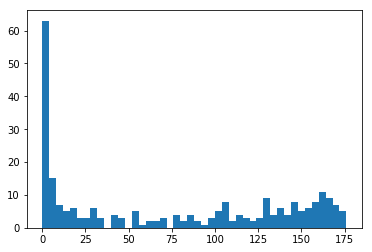

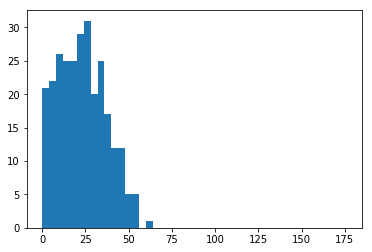

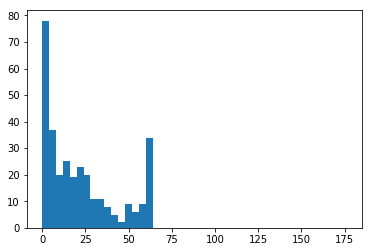

In [197]:
def plot_degree_dist(G, bins = 20):
    degrees = [G.degree(n) for n in G.nodes()]
    plt.hist(degrees, bins)
    plt.show()
    
# not demeaned
# Cosine sin demeaning. Th at q = .7
edges = pd.DataFrame(cosine_similarity(X.fillna(0)).stack(), columns = [similarity_colname])
edges_s = edges.loc[edges[similarity_colname] > edges[similarity_colname].quantile(.7)]
edges_s.index.names = ['industry_code_x', 'industry_code_y']
edges_s = edges_s.reset_index().merge(
    industry_titles, left_on = 'industry_code_x', right_on = 'industry_code').merge(
    industry_titles, left_on = 'industry_code_y', right_on = 'industry_code').T.drop_duplicates().T
edges_s[similarity_colname] = edges_s[similarity_colname].astype(float)

G1 = nx.from_pandas_edgelist(edges_s.reset_index(), 'industry_code_x', 'industry_code_y', weight_column)
plot_degree_dist(G1, np.arange(0, 180, 4))

# Demeaned cosine. Th at q=.9
#demeaned. btw this is the adjancency for cluistering
edges0 = pd.DataFrame(adjacencyM.stack(), columns = [similarity_colname])
edges0_s = edges0.loc[edges0[similarity_colname] > edges0[similarity_colname].quantile(.94)]
edges0_s.index.names = ['industry_code_x', 'industry_code_y']

G0 = nx.from_pandas_edgelist(edges0_s.reset_index(), 'industry_code_x', 'industry_code_y', weight_column)
plot_degree_dist(G0, np.arange(0, 180, 4))

# Demeaned cosine. Th at q=.9, added MAX degree
max_d = 60
df1 = edges_s.groupby('industry_code_x').apply(lambda x: x.nlargest(max_d, weight_column)).reset_index(drop = True)
df2 = edges_s.groupby('industry_code_y').apply(lambda x: x.nlargest(max_d, weight_column)).reset_index(drop = True)
edges_max_d = df1.merge(df2, on = ['industry_code_x', 'industry_title_x', 'industry_code_y', 'industry_title_x', weight_column]).reset_index(drop = True)

G2 = nx.from_pandas_edgelist(edges_max_d.reset_index(), 'industry_code_x', 'industry_code_y', weight_column)
plot_degree_dist(G2, np.arange(0, 180, 4))

In [198]:
##############################
# For the networkX plot 
##############################

edges = pd.DataFrame(adjacencyM.stack(), columns = [similarity_colname])
edges.index.names = ['industry_code_x', 'industry_code_y']

edges_s = edges.loc[edges[similarity_colname] > edges[similarity_colname].quantile(.90)]

edges_s = edges_s.reset_index().merge(
    industry_titles, left_on = 'industry_code_x', right_on = 'industry_code').merge(
    industry_titles, left_on = 'industry_code_y', right_on = 'industry_code').T.drop_duplicates().T
edges_s[similarity_colname] = edges_s[similarity_colname].astype(float)

# ### Max degree = max_d. Parameter used to trim the network.
# max_d = 40
# df1 = edges_s.groupby('industry_code_x').apply(lambda x: x.nlargest(max_d, weight_column)).reset_index(drop = True)
# df2 = edges_s.groupby('industry_code_y').apply(lambda x: x.nlargest(max_d, weight_column)).reset_index(drop = True)
# edges_max_d = df1.merge(df2, on = ['industry_code_x', 'industry_title_x', 'industry_code_y', 'industry_title_x', weight_column]).reset_index(drop = True)


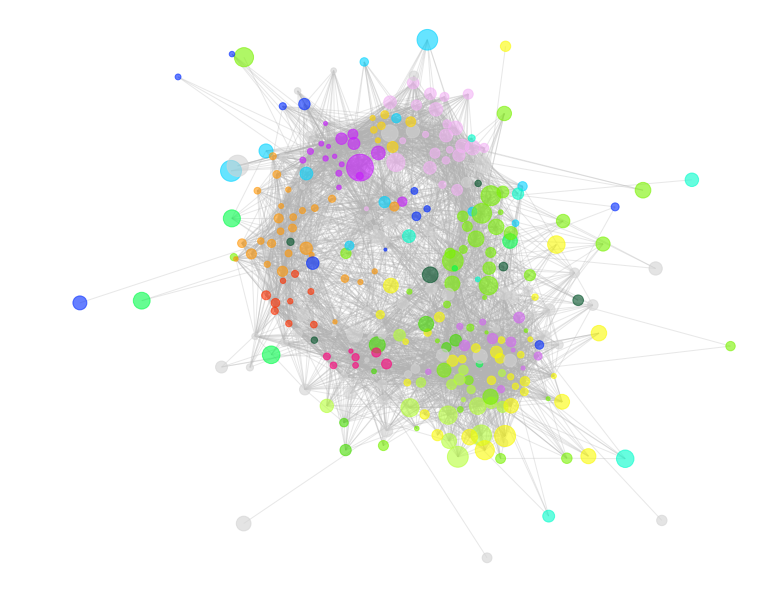

In [199]:

import matplotlib.colors as mcolors
import networkx as nx

nodes_size = pd.DataFrame(np.sqrt(X.sum()), columns=['sqrt_size'])
nodes = pd.concat([nodes_size, clust_result], axis = 1, sort = False)


norm = mcolors.Normalize(vmin=0, vmax=nodes['cluster'].nunique(), clip=True)
mapper = plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.gist_ncar)

nodes['color'] = nodes['cluster'].apply(lambda x: mcolors.rgb2hex(mapper.to_rgba(x)))
# nodes['color'] = nodes['color'].replace('#000080', '#9c28d2')
nodes.loc[nodes.cluster == 0, 'color'] = '#d3d3d3'

import json

# Hard threshold and max degree backboning

G = nx.from_pandas_edgelist(edges_s, 'industry_code_x', 'industry_code_y', weight_column)
# G = nx.from_pandas_edgelist(edges_max_d, 'industry_code_x', 'industry_code_y', weight_column)

plt.figure(figsize = (10, 8))

G = max(nx.connected_component_subgraphs(G), key=len)
nodes_s = nodes.loc[G.nodes.keys()]

## POSITIONS. Compute VS Load file
pos = nx.spring_layout(G, k=.4)

# f = open("./data/node_layout","w")
# f.write(json.dumps(pos, default=default))

# f = open('./data/node_layout', 'r')
# pos = json.loads(f.read())

nx.draw(G, pos, node_size = nodes_s.sqrt_size.values, alpha=.6, node_color= list(nodes_s.color.values), edgelist = [])
nx.draw_networkx_edges(G, pos, edge_color='.7', alpha=.3)
plt.show()

In [200]:
# nodes
pos_df = pd.DataFrame(pos, index = ['x', 'y']).T
pos_df['y'] = -pos_df['y']

nodes_wpos = pd.concat([nodes_s, pos_df], axis = 1, sort = False)
nodes_ = nodes_wpos.reset_index()[['index','x', 'y', 'industry_title', 'cluster', 'color']].dropna(subset = ['x']).rename({'index': 'id'}, axis = 1)
nodes_['id'] = nodes_['id'].astype(str).str.zfill(4)
nodes_[['x', 'y']] = 500 * nodes_[['x', 'y']]
nodes_['presence'] = True

nodes_.loc[nodes_.cluster == 0, 'color'] = '#d3d3d3' # Light gray, because cluster 0 would mean no cluster


## Wages and MFG-services color schemes
nodes_['color_mfg_srv'] = '#D3D3D3' #Gray bckg
conditions = [
    (nodes_['industry_title'].str.lower().str.contains('manufacturing')) + (nodes_['industry_title'].str.lower().str.contains('mfg')),
    (nodes_['industry_title'].str.lower().str.contains('service')),# or (nodes_['industry_title'].str.lower().str.contains('mfg')),
    (nodes_['industry_title'].str.lower().str.contains('wholesale')),# or (nodes_['industry_title'].str.lower().str.contains('mfg')),
    (-nodes_['industry_title'].str.lower().str.contains('naics'))]
choices = ['#000080', '#ffc400', '#00b0ff', '#FF0000']
nodes_['color_mfg_srv'] = np.select(conditions, choices, default='#D3D3D3')


def color_from_series(df, ix_col, val_col, cmap = plt.cm.coolwarm):
    import matplotlib.colors as mcolors

    # create color reference
    qlo = df[val_col].quantile(.2)
    qhi = df[val_col].quantile(.8)
    norm = mcolors.Normalize(vmin=qlo, vmax=qhi, clip=True)
    mapper = plt.cm.ScalarMappable(norm = norm, cmap=cmap)
    df['color'] = df[val_col].apply(lambda x: mcolors.to_hex(mapper.to_rgba(x))) 
    color = df[[ix_col, 'color']]
    return color

df_city = df_cnt.groupby(level = 1).sum()
avg_wages_indu = df_city[['total_annual_wages']].div(df_city[['annual_avg_emplvl']].values).dropna()
avg_wages_indu = np.log10(avg_wages_indu)
avg_wages_indu = avg_wages_indu.reset_index()
avg_wages_indu['industry_code'] = avg_wages_indu['industry_code'].astype(str)

wages_color = color_from_series(avg_wages_indu, 'industry_code', 'total_annual_wages', 
                                cmap = plt.cm.RdYlGn).rename(columns = {'color': 'wage_color'})

In [201]:
nodes_ = nodes_.merge(wages_color, how = 'left', left_on = 'id', right_on = 'industry_code')

In [202]:

##############################
# For the interactive network 
##############################

edges_df = edges_s # edges_max_d

edges_df['edge_tuple'] = list(zip(edges_df.industry_code_x, edges_df.industry_code_y))
edges_df['edge_tuple_rev'] = list(zip(edges_df.industry_code_y, edges_df.industry_code_x))
edges_triangles = edges_df.loc[edges_df.edge_tuple.isin(G.edges()) | edges_df.edge_tuple_rev.isin(G.edges())]

links = edges_triangles.reset_index().rename({weight_column: 'strength'},axis = 1)
links['target'] = links['industry_code_y'].astype(str).str.zfill(4)
links['source'] = links['industry_code_x'].astype(str).str.zfill(4)

In [203]:
network = '{"nodes": '+nodes_.to_json(orient= 'records')+', "edges": '+links[['index', 'source', 'target']].to_json(orient= 'records')+'}\n'

In [204]:
nodes_.loc[nodes_.industry_code.isna(), 'color'] = '#FF0000'
nodes_.loc[nodes_.industry_code.isna(), 'wage_color'] = '#FF0000'

# nodes['cluster'] = nodes['cluster'].astype(float).astype(int)
nodes.loc[nodes.cluster.isna(), 'cluster'] = 0
nodes.loc[nodes.cluster.isna(), 'industry_title'] = 'wages'

In [205]:
name = 'wages'; color = 'wage_color';

ps = d3plus.ProductSpace(
id="name",
name="industry_title",
color=color,
graph_data=network,
presence="presence",
edge_property="edges",
network_id="id")

ps.draw(nodes_)
name = name
visualization_html = ps.dump_html(nodes_)
file_ = name + '_nwplot.html'
link = "http://matiasdice.com/other/"+file_
open('./html/'+file_, "w+").write(visualization_html);

<IPython.core.display.Javascript object>

In [206]:
name = 'anchors'; color = 'color_mfg_srv';

ps = d3plus.ProductSpace(
id="name",
name="industry_title",
color=color,
graph_data=network,
presence="presence",
edge_property="edges",
network_id="id")

ps.draw(nodes_)
name = name
visualization_html = ps.dump_html(nodes_)
file_ = name + '_nwplot.html'
link = "http://matiasdice.com/other/"+file_
open('./html/'+file_, "w+").write(visualization_html);

<IPython.core.display.Javascript object>

In [224]:
name = 'clusters'; color = 'color';

ps = d3plus.ProductSpace(
id="name",
name="industry_title",
color=color,
graph_data=network,
presence="presence",
edge_property="edges",
network_id="id")

ps.draw(nodes_)
name = name
visualization_html = ps.dump_html(nodes_)
file_ = name + '_nwplot.html'
link = "http://matiasdice.com/other/"+file_
open('./html/'+file_, "w+").write(visualization_html);

<IPython.core.display.Javascript object>

## Save partial results

In [208]:
nodes.head()

sqrt_size  cluster  \
1114  91.597125   9         
1119  105.039278  15        
1121  110.553682  15        
1129  50.454105   15        
1132  15.152008   15        

                                               industry_title    color  
1114  NAICS 1114 Greenhouse and nursery production             #fafa04  
1119  NAICS 1119 Other crop farming                            #d468f3  
1121  NAICS 1121 Cattle ranching and farming                   #d468f3  
1129  NAICS 1129 Other animal production                       #d468f3  
1132  NAICS 1132 Forest nursery and gathering forest products  #d468f3

In [209]:
# nodes.loc[nodes.cluster == int(col)].sort_values('industry_code')

In [210]:
nodes.reset_index().rename(columns = {'index': 'industry_code'}).to_csv('./../data/naics_cluster_color.csv')

## Colored Counties

In [211]:
df_cnt = pd.read_csv('./data/naics_area_cnt_02_07.csv', index_col=[0, 1])
df_cnt = df_cnt.loc[~(df_cnt.index.get_level_values('industry_code') == 9999)] # Drop the unclassified!
X = df_cnt.unstack()[variable]

X.columns = X.columns.astype(str)
X.index = X.index.astype(str).str.zfill(5)

In [212]:
nodes = pd.read_csv('./../data/naics_cluster_color.csv', index_col=0, dtype = str)
area_indu = X.stack().reset_index().rename(columns = {0: 'level'})

county_indu_names = area_indu.merge(nodes[['industry_code', 'cluster', 'industry_title']]).dropna(subset = ['level'])
county_indu_names = county_indu_names.sort_values('level', ascending = False).groupby(['area_fips', 'cluster']).first()
county_indu_names = county_indu_names.loc[county_indu_names.level > 2.9]['industry_title']

In [213]:
X_area_cluster = pd.concat([nodes.set_index('industry_code')[['cluster']], X.T], axis = 1, sort = False)
X_area_cluster = X_area_cluster.loc[X.columns]
X_area_cluster = X_area_cluster.groupby('cluster').sum().T
X_area_cluster.columns = X_area_cluster.columns.astype(str).str.zfill(2)
X_area_cluster = X_area_cluster.sort_index(axis = 1)
# X_area_cluster.to_csv('./data/X_county_cluster.csv')

In [214]:
# nodes
import geopandas as gpd

counties = gpd.read_file('./data/cb_2017_us_county_500k/cb_2017_us_county_500k.shp')
counties['area_fips'] = counties.STATEFP + counties.COUNTYFP
counties = counties.set_index('area_fips')[['geometry']]

In [215]:
# n_clusters = 10
# gdf_names = gpd.GeoDataFrame(pd.concat([county_indu_names.unstack().fillna(''), gdf_scaled_std], axis = 1, sort = False))
# gdf_names.columns = list(gdf_names.columns[:n_clusters].astype(int).astype(str) + '_nam') + list(gdf_names.columns[n_clusters:2*n_clusters].astype(int).astype(str) + '_val') + ['geometry']
# gdf_names.crs = {'init': 'epsg:3395'}
# gdf_names = gdf_names.dropna()
# gdf_names = gdf_names.to_crs({'init': 'epsg:4326'})
# # save_geojson(gdf_names, 'cnty_indu_names.geojson')

## Plot Maps

In [216]:
fancy_crs = {u'datum': u'NAD83',
 u'lat_0': 23,
 u'lat_1': 29.5,
 u'lat_2': 45.5,
 u'lon_0': -96,
 u'no_defs': True,
 u'proj': u'aea',
 u'units': u'm',
 u'x_0': 0,
 u'y_0': 0}

In [217]:
import matplotlib.cm as cm
import matplotlib.colors as colors


In [218]:
gdf = gpd.GeoDataFrame(pd.concat([X_area_cluster, counties], axis = 1, sort = True).dropna())
gdf.columns = list(gdf.columns[:-1].values.astype(float).astype(int).astype(str)) + ['geometry']
gdf.crs = {'init': 'epsg:4326'}
gdf = gdf.to_crs({'init': 'epsg:3395'})

# gdf_scaled = gdf.copy()
# # gdf_scaled
# M = gdf_scaled.iloc[:, :-1]
# gdf_scaled.iloc[:, :-1] = np.log10(M.div(M.sum()).T.div(M.T.sum()).T*M.sum().sum()).replace(-np.inf, np.nan)#

# gdf_scaled.iloc[:, :-1] = gdf_scaled.iloc[:, :-1] / gdf_scaled.iloc[:, :-1].std()
# gdf_scaled.iloc[:, :-1] = gdf_scaled.iloc[:, :-1].fillna(-4)

# gdf_scaled.crs = {'init': 'epsg:3395'}
# gdf_scaled = gdf_scaled.to_crs({'init': 'epsg:4326'})

In [219]:
gdf_scaled = gdf.copy()
M = gdf_scaled.iloc[:, :-1]
gdf_scaled.iloc[:, :-1] = np.log10(M.div(M.sum()).T.div(M.T.sum()).T*M.sum().sum()).replace(-np.inf, np.nan)#

gdf_scaled.iloc[:, :-1] = gdf_scaled.iloc[:, :-1] / gdf_scaled.iloc[:, :-1].std()
# gdf_scaled.iloc[:, :-1] = gdf_scaled.iloc[:, :-1].fillna(-2)

# # STANDARIZATION countywise
county_std = gdf_scaled.iloc[:, :-1].std(1).reset_index().rename(columns = {0: 'county_std', 'index': 'area_fips'})

county_size = X.sum(1).reset_index().rename(columns = {0: 'no_establishments'})
county_size['log_no_establishments'] = np.log10(county_size['no_establishments'])
county_size['county_std_ratio'] = np.clip(4 - county_size['log_no_establishments'], 1, np.inf)

gdf_scaled_std = gdf_scaled.copy()
factor = county_size.set_index('area_fips')[['county_std_ratio']].loc[gdf_scaled_std.index]
gdf_scaled_std.iloc[:, :-1] = gdf_scaled_std.iloc[:, :-1].div(factor.county_std_ratio, 0)
gdf_scaled_std.iloc[:, :-1] = gdf_scaled_std.iloc[:, :-1].fillna(-2)


/home/miglesia/anaconda2/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()
/home/miglesia/anaconda2/lib/python2.7/site-packages/IPython/kernel/__main__.py:12: RuntimeWarning: divide by zero encountered in log10


industry_code      sqrt_size cluster  \
184  1111          76.3466873326  0        
9    2211          80.8891216419  0        
14   2371          150.728287546  0        
297  3114          41.1108258248  0        
194  3115          38.5136339496  0        
23   3118          108.492703288  0        
292  3119          54.2876597396  0        
196  3121          58.7254913418  0        
207  3271          42.6442649524  0        
208  3279          51.8025095917  0        
209  3313          24.1326196948  0        
34   3323          119.565463241  0        
216  3334          42.4939211339  0        
223  3362          44.9336547961  0        
281  3365          15.4757875405  0        
226  3369          28.4068653674  0        
228  3379          32.7052493238  0        
229  4235          92.2195749285  0        
49   4237          141.734905134  0        
51   4239          176.437760509  0        
53   4244          185.995654071  0        
55   4246          119.528518215  0        
56   4247          88.4812597861  0        
72   4481          278.12026775   0        
73   4482          154.048206741  0        
75   4511          206.300024237  0        
79   4531          142.928303705  0        
82   4539          217.794283672  0        
233  4542          70.8772412932  0        
282  4811          51.4975727583  0        
85   4841          258.390853811  0        
284  4869          19.8926284504  0        
91   4882          31.0456652906  0        
239  4883          53.0386651416  0        
92   4884          96.4590586726  0        
288  4889          41.0905504141  0        
240  4921          91.2125722329  0        
101  5171          129.311832405  0        
105  5181          97.0371063048  0        
107  5191          86.1309081186  0        
244  5259          64.6422204652  0        
116  5313          269.287021596  0        
118  5322          174.157017277  0        
250  5622          61.1930006891  0        
140  6116          176.884990884  0        
141  6211          453.86325033   0        
254  6215          108.068728132  0        
146  6219          89.0482079176  0        
149  6232          144.972008793  0        
150  6233          134.255167498  0        
257  6243          95.3781072015  0        
154  7112          74.7336381201  0        
164  8111          407.424655611  0        
166  8113          156.759741856  0        
172  8131          135.928228611  0        
174  8134          168.662779929  0        
177  9211          202.831251701  0        
178  9221          162.472664367  0        
179  9231          114.098349389  0        
180  9241          119.388441652  0        
181  9261          145.60895119   0        
183  9281          55.876948139   0        

                                               industry_title    color  
184  NAICS 1111 Oilseed and grain farming                      #d3d3d3  
9    NAICS 2211 Power generation and supply                    #d3d3d3  
14   NAICS 2371 Utility system construction                    #d3d3d3  
297  NAICS 3114 Fruit and vegetable preserving and specialty   #d3d3d3  
194  NAICS 3115 Dairy product manufacturing                    #d3d3d3  
23   NAICS 3118 Bakeries and tortilla manufacturing            #d3d3d3  
292  NAICS 3119 Other food manufacturing                       #d3d3d3  
196  NAICS 3121 Beverage manufacturing                         #d3d3d3  
207  NAICS 3271 Clay product and refractory manufacturing      #d3d3d3  
208  NAICS 3279 Other nonmetallic mineral products             #d3d3d3  
209  NAICS 3313 Alumina and aluminum production                #d3d3d3  
34   NAICS 3323 Architectural and structural metals mfg.       #d3d3d3  
216  NAICS 3334 Hvac and commercial refrigeration equipment    #d3d3d3  
223  NAICS 3362 Motor vehicle body and trailer manufacturing   #d3d3d3  
281  NAICS 3365 Railroad rolling stock manufacturing           #d3d3d3  
226  NAICS 3369 Other transportation equipment manufacturing   

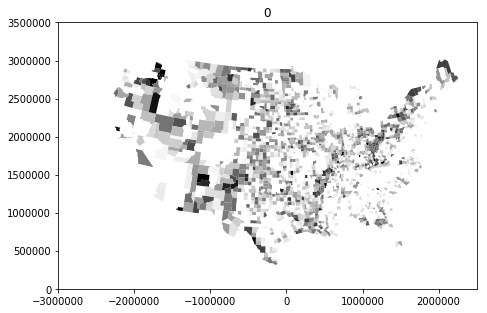

industry_code      sqrt_size cluster  \
193  3113          42.4146201209  1        
42   3391          113.436839989  1        
89   4859          53.3307291031  1        
137  6111          250.304780884  1        
251  6112          42.177995843   1        
144  6214          134.276704358  1        
151  6239          76.5676171759  1        
161  7222          480.408645495  1        

                                               industry_title    color  
193  NAICS 3113 Sugar and confectionery product manufacturing  #005127  
42   NAICS 3391 Medical equipment and supplies manufacturing   #005127  
89   NAICS 4859 Other ground passenger transportation          #005127  
137  NAICS 6111 Elementary and secondary schools               #005127  
251  NAICS 6112 Junior colleges                                #005127  
144  NAICS 6214 Outpatient care centers                        #005127  
151  NAICS 6239 Other residential care facilities              #005127  
161  NAICS07 7222 Limited-service eating places                #005127

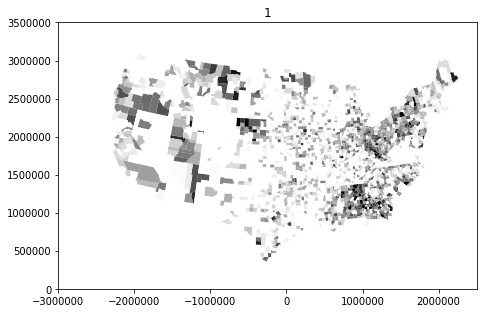

industry_code      sqrt_size cluster  \
25   3141          51.1183267853  2        
26   3149          63.9604044182  2        
31   3231          195.578373038  2        
290  3341          41.3819606431  2        
293  3342          48.1366111534  2        
219  3344          76.68322285    2        
41   3371          130.371840006  2        
69   4453          158.635431099  2        
301  4851          30.3218842862  2        
236  4855          34.7534170982  2        
142  6212          340.223872374  2        
147  6221          74.306347867   2        
182  9271          9.28977933     2        

                                             industry_title    color  
25   NAICS 3141 Textile furnishings mills                    #002aff  
26   NAICS 3149 Other textile product mills                  #002aff  
31   NAICS 3231 Printing and related support activities      #002aff  
290  NAICS 3341 Computer and peripheral equipment mfg.       #002aff  
293  NAICS 3342 Communications equipment manufacturing       #002aff  
219  NAICS 3344 Semiconductor and electronic component mfg.  #002aff  
41   NAICS 3371 Household and institutional furniture mfg.   #002aff  
69   NAICS 4453 Beer, wine, and liquor stores                #002aff  
301  NAICS 4851 Urban transit systems                        #002aff  
236  NAICS 4855 Charter bus industry                         #002aff  
142  NAICS 6212 Offices of dentists                          #002aff  
147  NAICS 6221 General medical and surgical hospitals       #002aff  
182  NAICS 9271 Space research and technology                #002aff

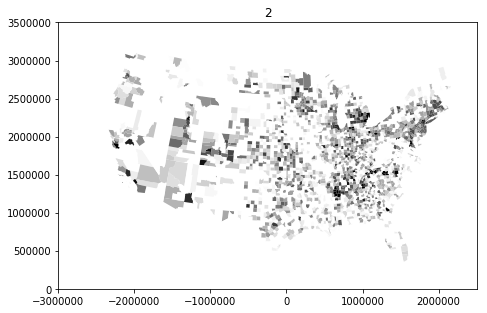

industry_code      sqrt_size cluster  \
68   4452          165.090934538  3        
87   4853          82.0953713677  3        
93   4885          127.094977609  3        
95   4922          72.2144953132  3        
103  5173          85.906732371   3        
120  5411          427.379339697  3        
256  6242          87.957660269   3        
156  7121          78.1771492616  3        
159  7213          44.0743689688  3        
160  7221          440.205293017  3        
170  8123          196.62977055   3        

                                                industry_title    color  
68   NAICS 4452 Specialty food stores                           #00d3ff  
87   NAICS 4853 Taxi and limousine service                      #00d3ff  
93   NAICS 4885 Freight transportation arrangement              #00d3ff  
95   NAICS 4922 Local messengers and local delivery             #00d3ff  
103  NAICS 5173 Wired and wireless telecommunications carriers  #00d3ff  
120  NAICS 5411 Legal services                                  #00d3ff  
256  NAICS 6242 Emergency and other relief services             #00d3ff  
156  NAICS 7121 Museums, historical sites, zoos, and parks      #00d3ff  
159  NAICS 7213 Rooming and boarding houses                     #00d3ff  
160  NAICS07 7221 Full-service restaurants                      #00d3ff  
170  NAICS 8123 Drycleaning and laundry services                #00d3ff

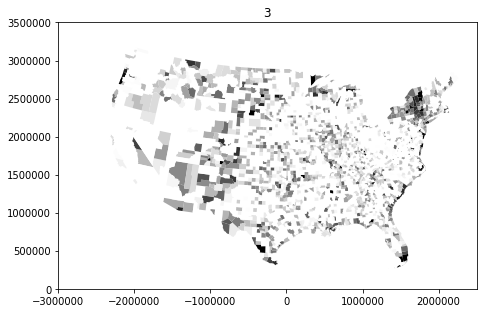

industry_code      sqrt_size cluster  \
203  3254          48.5643902464  4        
64   4431          232.112149617  4        
81   4533          127.817447948  4        
237  4871          24.5339900274  4        
110  5223          182.571264625  4        
115  5312          306.186381147  4        
121  5412          345.375833936  4        
134  5616          160.469882948  4        
162  7223          163.3472273    4        
167  8114          141.690448984  4        

                                             industry_title    color  
203  NAICS 3254 Pharmaceutical and medicine manufacturing    #00fdcb  
64   NAICS 4431 Electronics and appliance stores             #00fdcb  
81   NAICS 4533 Used merchandise stores                      #00fdcb  
237  NAICS 4871 Scenic and sightseeing transportation, land  #00fdcb  
110  NAICS 5223 Activities related to credit intermediation  #00fdcb  
115  NAICS 5312 Offices of real estate agents and brokers    #00fdcb  
121  NAICS 5412 Accounting and bookkeeping services          #00fdcb  
134  NAICS 5616 Investigation and security services          #00fdcb  
162  NAICS 7223 Special food services                        #00fdcb  
167  NAICS 8114 Household goods repair and maintenance       #00fdcb

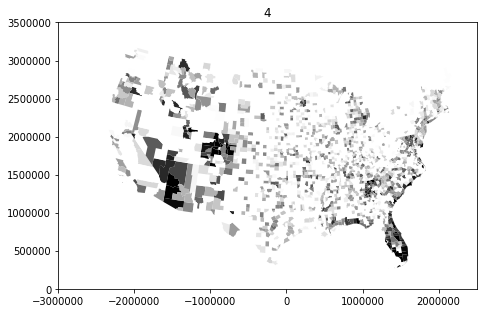

industry_code      sqrt_size cluster  \
195  3117          28.7245539565  5        
62   4421          163.035987847  5        
63   4422          177.547036021  5        
67   4451          291.379391859  5        
70   4461          282.833814574  5        
80   4532          213.303578654  5        
238  4872          41.9058468474  5        
117  5321          117.213480453  5        
143  6213          319.435048171  5        
152  6241          216.479598731  5        
168  8121          311.439641022  5        

                                              industry_title    color  
195  NAICS 3117 Seafood product preparation and packaging     #00fd49  
62   NAICS 4421 Furniture stores                              #00fd49  
63   NAICS 4422 Home furnishings stores                       #00fd49  
67   NAICS 4451 Grocery stores                                #00fd49  
70   NAICS 4461 Health and personal care stores               #00fd49  
80   NAICS 4532 Office supplies, stationery, and gift stores  #00fd49  
238  NAICS 4872 Scenic and sightseeing transportation, water  #00fd49  
117  NAICS 5321 Automotive equipment rental and leasing       #00fd49  
143  NAICS 6213 Offices of other health practitioners         #00fd49  
152  NAICS 6241 Individual and family services                #00fd49  
168  NAICS 8121 Personal care services                        #00fd49

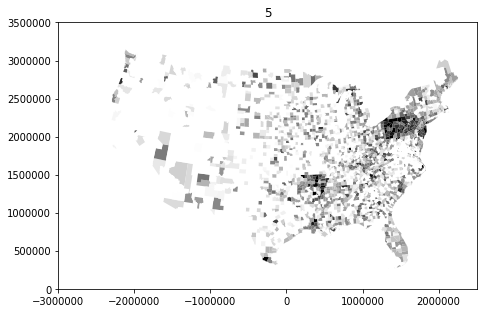

industry_code      sqrt_size cluster  \
13   2362          226.266988312  6        
17   2379          87.7265638219  6        
46   4233          135.853474989  6        
50   4238          255.783371886  6        
235  4832          22.6270487102  6        
245  5323          73.649620954   6        
145  6216          127.467250696  6        

                                               industry_title    color  
13   NAICS 2362 Nonresidential building construction           #46dd00  
17   NAICS 2379 Other heavy construction                       #46dd00  
46   NAICS 4233 Lumber and const. supply merchant wholesalers  #46dd00  
50   NAICS 4238 Machinery and supply merchant wholesalers      #46dd00  
235  NAICS 4832 Inland water transportation                    #46dd00  
245  NAICS 5323 General rental centers                         #46dd00  
145  NAICS 6216 Home health care services                      #46dd00

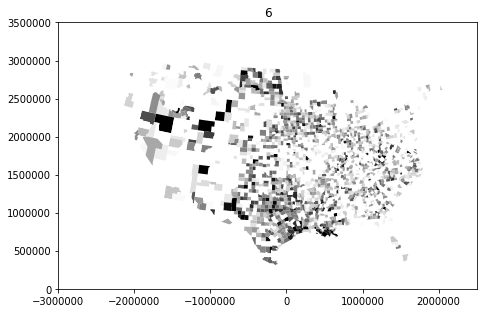

industry_code      sqrt_size cluster  \
265  2122          16.4078233373  7        
15   2372          110.219402406  7        
299  3122          15.3595789873  7        
47   4234          226.800903878  7        
48   4236          172.249770198  7        
52   4241          108.799816176  7        
230  4242          102.080278866  7        
232  4248          63.5387021166  7        
58   4251          431.460156523  7        
234  4812          50.8317486092  7        
307  4821          10.2037574778  7        
308  4831          27.4168439711  7        
309  4852          21.0633963706  7        
294  4879          13.7149553408  7        
90   4881          78.6535652932  7        
302  5112          99.626385394   7        
102  5172          98.1807007512  7        
104  5175          52.4170773699  7        
303  5179          22.4659000858  7        
106  5182          110.683708527  7        
310  5211          15.3877657031  7        
109  5222          234.402929447  7        
112  5241          196.439473291  7        
113  5242          368.411115467  7        
119  5324          101.250843618  7        
122  5413          346.914590834  7        
123  5415          385.590434702  7        
124  5416          397.372348476  7        
125  5417          142.000880279  7        
127  5419          245.787882804  7        
128  5511          201.453675403  7        
129  5611          182.828881745  7        
130  5612          47.6215987412  7        
131  5613          253.191495381  7        
132  5614          207.070277925  7        
248  5619          155.393961702  7        
139  6114          97.7692862474  7        
252  6115          88.2214070771  7        
255  6223          33.6298478538  7        
165  8112          125.179937157  7        
175  8139          239.021930654  7        

                                               industry_title    color  
265  NAICS 2122 Metal ore mining                               #7af200  
15   NAICS 2372 Land subdivision                               #7af200  
299  NAICS 3122 Tobacco manufacturing                          #7af200  
47   NAICS 4234 Commercial equip. merchant wholesalers         #7af200  
48   NAICS 4236 Appliance and electric goods merchant whls.    #7af200  
52   NAICS 4241 Paper and paper product merchant wholesalers   #7af200  
230  NAICS 4242 Druggists' goods merchant wholesalers          #7af200  
232  NAICS 4248 Alcoholic beverage merchant wholesalers        #7af200  
58   NAICS 4251 Electronic markets and agents and brokers      #7af200  
234  NAICS 4812 Nonscheduled air transportation                #7af200  
307  NAICS 4821 Rail transportation                            #7af200  
308  NAICS 4831 Sea, coastal, and great lakes transportation   #7af200  
309  NAICS 4852 Interurban and rural bus transportation        #7af200  
294  NAICS 4879 Scenic and sightseeing transportation, other   #7af200  
90   NAICS 4881 Support activities for air transportation      #7af200  
302  NAICS 5112 Software publishers                            #7af200  
102  NAICS12 5172 Wireless telecommunications carriers         #7af200  
104  NAICS02 5175 Cable and other program distribution         #7af200  
303  NAICS 5179 Other telecommunications                       #7af200  
106  NAICS 5182 Data processing, hosting and related services  #7af200  
310  NAICS 5211 Monetary authorities - central bank            #7af200  
109  NAICS 5222 Nondepository credit intermediation            #7af200  
112  NAICS 5241 Insurance carriers                             #7af200  
113  NAICS 5242 Insurance agencies and brokerages              #7af200  
119  NAICS 5324 Machinery and equipment rental and leasing     #7af200  
122  NAICS 5413 Architectural and engineering services         #7af200  
123  NAICS 5415 Computer systems design and related services   #7af200  
124  NAICS 5416 Management and technical consulting services   #7af200  
125  NAICS 5417 Scientific research an

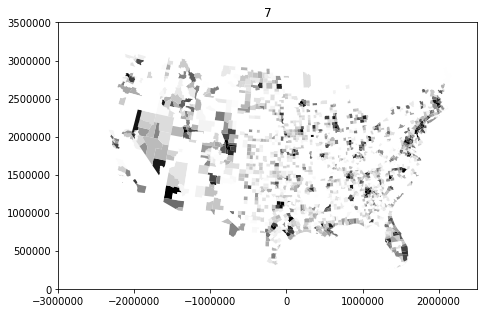

industry_code      sqrt_size cluster  \
275  1142          17.8395627749  8        
8    2123          68.7003153802  8        
11   2213          99.1869447054  8        
16   2373          126.300501451  8        
18   2381          337.304931281  8        
19   2382          435.546763658  8        
21   2389          281.72806037   8        
33   3273          92.0650132606  8        
59   4411          223.086717071  8        
60   4412          124.446574883  8        
66   4442          129.69586218   8        
71   4471          328.867754576  8        
78   4529          179.426772436  8        
135  5617          421.055756403  8        
136  5629          90.9405483452  8        
285  7132          49.0372307538  8        
169  8122          136.873968794  8        

                                               industry_title    color  
275  NAICS 1142 Hunting and trapping                           #b6ff38  
8    NAICS 2123 Nonmetallic mineral mining and quarrying       #b6ff38  
11   NAICS 2213 Water, sewage and other systems                #b6ff38  
16   NAICS 2373 Highway, street, and bridge construction       #b6ff38  
18   NAICS 2381 Building foundation and exterior contractors   #b6ff38  
19   NAICS 2382 Building equipment contractors                 #b6ff38  
21   NAICS 2389 Other specialty trade contractors              #b6ff38  
33   NAICS 3273 Cement and concrete product manufacturing      #b6ff38  
59   NAICS 4411 Automobile dealers                             #b6ff38  
60   NAICS 4412 Other motor vehicle dealers                    #b6ff38  
66   NAICS 4442 Lawn and garden equipment and supplies stores  #b6ff38  
71   NAICS 4471 Gasoline stations                              #b6ff38  
78   NAICS12 4529 Other general merchandise stores             #b6ff38  
135  NAICS 5617 Services to buildings and dwellings            #b6ff38  
136  NAICS 5629 Remediation and other waste services           #b6ff38  
285  NAICS 7132 Gambling industries                            #b6ff38  
169  NAICS 8122 Death care services                            #b6ff38

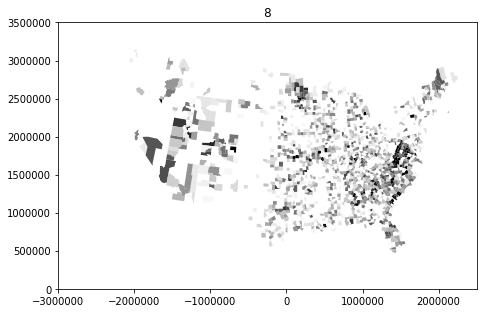

industry_code      sqrt_size cluster  \
0    1114          91.5971251368  9        
277  1122          40.8246249217  9        
298  1125          25.56560189    9        
187  1131          23.4964536331  9        
5    1133          95.9190631036  9        
188  1141          45.1706025345  9        
189  1152          61.685762809   9        
7    1153          44.5978325333  9        
295  2121          32.3011867687  9        
12   2361          441.549714075  9        
20   2383          367.110905132  9        
28   3211          59.3076723536  9        
198  3212          39.6507671216  9        
29   3219          97.7855647152  9        
225  3366          40.3637626261  9        
54   4245          75.8119383738  9        
61   4413          227.394444377  9        
65   4441          240.31645803   9        
77   4521          107.112946619  9        
84   4543          125.340735597  9        
86   4842          213.096144185  9        
88   4854          68.4407286149  9        
94   4911          140.712768906  9        
108  5221          306.116072757  9        
249  5621          87.020208381   9        
148  6231          124.738526526  9        
153  6244          252.247695728  9        
261  7131          46.7204452034  9        
157  7139          242.164062844  9        
158  7211          221.731481752  9        
262  7212          73.3106404282  9        
163  7224          219.012861114  9        
264  9251          54.7297907908  9        

                                              industry_title    color  
0    NAICS 1114 Greenhouse and nursery production             #fafa04  
277  NAICS 1122 Hog and pig farming                           #fafa04  
298  NAICS 1125 Aquaculture                                   #fafa04  
187  NAICS 1131 Timber tract operations                       #fafa04  
5    NAICS 1133 Logging                                       #fafa04  
188  NAICS 1141 Fishing                                       #fafa04  
189  NAICS 1152 Support activities for animal production      #fafa04  
7    NAICS 1153 Support activities for forestry               #fafa04  
295  NAICS 2121 Coal mining                                   #fafa04  
12   NAICS 2361 Residential building construction             #fafa04  
20   NAICS 2383 Building finishing contractors                #fafa04  
28   NAICS 3211 Sawmills and wood preservation                #fafa04  
198  NAICS 3212 Plywood and engineered wood product mfg.      #fafa04  
29   NAICS 3219 Other wood product manufacturing              #fafa04  
225  NAICS 3366 Ship and boat building                        #fafa04  
54   NAICS 4245 Farm product raw material merch. whls.        #fafa04  
61   NAICS 4413 Auto parts, accessories, and tire stores      #fafa04  
65   NAICS 4441 Building material and supplies dealers        #fafa04  
77   NAICS12 4521 Department stores                           #fafa04  
84   NAICS 4543 Direct selling establishments                 #fafa04  
86   NAICS 4842 Specialized freight trucking                  #fafa04  
88   NAICS 4854 School and employee bus transportation        #fafa04  
94   NAICS 4911 Postal service                                #fafa04  
108  NAICS 5221 Depository credit intermediation              #fafa04  
249  NAICS 5621 Waste collection                              #fafa04  
148  NAICS 6231 Nursing care facilities, skilled nursing      #fafa04  
153  NAICS 6244 Child day care services                       #fafa04  
261  NAICS 7131 Amusement parks and arcades                   #fafa04  
157  NAICS 7139 Other amusement and recreation industries     #fafa04  
158  NAICS 7211 Traveler accommodation                        #fafa04  
262  NAICS 7212 Rv parks and recreational camps               #fafa04  
163  NAICS 7224 Drinking places, alcoholic beverages          #fafa04  
264  NAICS 9251 Community and housing program administration  #fafa04

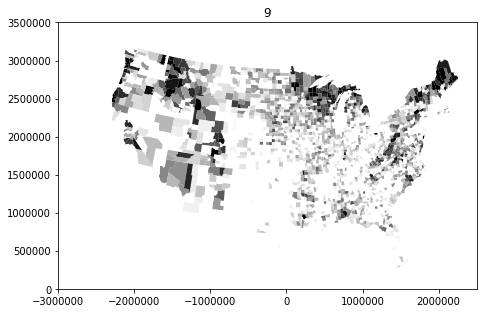

industry_code      sqrt_size cluster  \
278  3133          43.5962536617  10       
276  3159          26.341348991   10       
27   3169          26.6239240784  10       
231  4243          120.319020386  10       
242  5122          61.9394865978  10       
258  7111          98.2726649006  10       
260  7114          57.3108483041  10       

                                              industry_title    color  
278  NAICS 3133 Textile and fabric finishing mills            #ffd502  
276  NAICS 3159 Accessories and other apparel manufacturing   #ffd502  
27   NAICS 3169 Other leather product manufacturing           #ffd502  
231  NAICS 4243 Apparel and piece goods merchant wholesalers  #ffd502  
242  NAICS 5122 Sound recording industries                    #ffd502  
258  NAICS 7111 Performing arts companies                     #ffd502  
260  NAICS 7114 Agents and managers for public figures        #ffd502

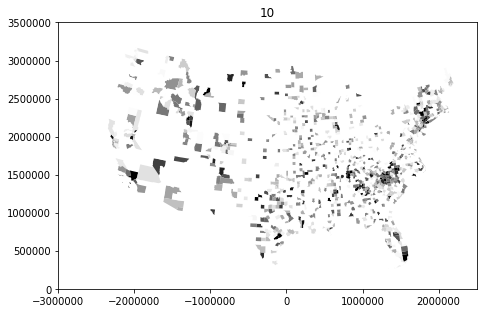

industry_code      sqrt_size cluster  \
306  3112          26.9845634885  11       
22   3116          57.7293974794  11       
30   3221          26.8188366638  11       
199  3222          66.6975761679  11       
204  3255          42.7235298167  11       
205  3256          49.3472390312  11       
32   3261          103.068908988  11       
267  3262          45.3997063133  11       
271  3272          45.1576866842  11       
300  3311          27.126555255   11       
210  3314          29.0031607473  11       
211  3315          45.8804606196  11       
269  3321          49.1205998878  11       
212  3322          37.3755713446  11       
214  3325          24.6860284372  11       
273  3326          38.3597010763  11       
35   3327          152.767852203  11       
36   3328          83.0505869937  11       
287  3332          62.7257257165  11       
215  3333          51.6415530363  11       
274  3335          104.200927699  11       
220  3345          83.1963540868  11       
279  3352          21.0542948904  11       
222  3359          46.2938080813  11       
280  3361          19.3140708638  11       
40   3363          76.2633594854  11       
227  3372          60.4480493206  11       
44   4231          155.108510405  11       
96   4931          113.382391343  11       

                                               industry_title    color  
306  NAICS 3112 Grain and oilseed milling                      #ff990a  
22   NAICS 3116 Animal slaughtering and processing             #ff990a  
30   NAICS 3221 Pulp, paper, and paperboard mills              #ff990a  
199  NAICS 3222 Converted paper product manufacturing          #ff990a  
204  NAICS 3255 Paint, coating, and adhesive manufacturing     #ff990a  
205  NAICS 3256 Soap, cleaning compound, and toiletry mfg.     #ff990a  
32   NAICS 3261 Plastics product manufacturing                 #ff990a  
267  NAICS 3262 Rubber product manufacturing                   #ff990a  
271  NAICS 3272 Glass and glass product manufacturing          #ff990a  
300  NAICS 3311 Iron and steel mills and ferroalloy mfg.       #ff990a  
210  NAICS 3314 Other nonferrous metal production              #ff990a  
211  NAICS 3315 Foundries                                      #ff990a  
269  NAICS 3321 Forging and stamping                           #ff990a  
212  NAICS 3322 Cutlery and handtool manufacturing             #ff990a  
214  NAICS 3325 Hardware manufacturing                         #ff990a  
273  NAICS 3326 Spring and wire product manufacturing          #ff990a  
35   NAICS 3327 Machine shops and threaded product mfg.        #ff990a  
36   NAICS 3328 Coating, engraving, and heat treating metals   #ff990a  
287  NAICS 3332 Industrial machinery manufacturing             #ff990a  
215  NAICS 3333 Commercial and service industry machinery      #ff990a  
274  NAICS 3335 Metalworking machinery manufacturing           #ff990a  
220  NAICS 3345 Electronic instrument manufacturing            #ff990a  
279  NAICS 3352 Household appliance manufacturing              #ff990a  
222  NAICS 3359 Other electrical equipment and component mfg.  #ff990a  
280  NAICS 3361 Motor vehicle manufacturing                    #ff990a  
40   NAICS 3363 Motor vehicle parts manufacturing              #ff990a  
227  NAICS 3372 Office furniture and fixtures manufacturing    #ff990a  
44   NAICS 4231 Motor vehicle and parts merchant wholesalers   #ff990a  
96   NAICS 4931 Warehousing and storage                        #ff990a

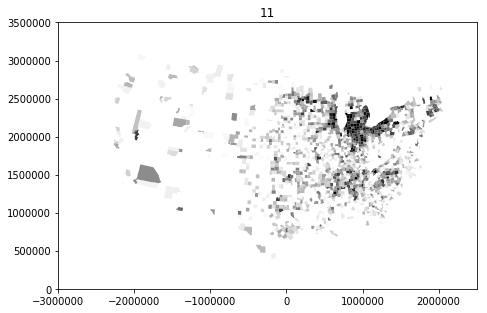

industry_code      sqrt_size cluster  \
291  3241          45.7126897043  12       
201  3252          35.7952510817  12       
206  3259          52.5282463696  12       
268  3312          29.3975622572  12       
213  3324          41.8855583704  12       
37   3329          78.1040972037  12       
217  3336          29.8844998843  12       
218  3339          80.9617193493  12       
39   3353          50.25783521    12       

                                               industry_title    color  
291  NAICS 3241 Petroleum and coal products manufacturing      #ff3000  
201  NAICS 3252 Resin, rubber, and artificial fibers mfg.      #ff3000  
206  NAICS 3259 Other chemical product and preparation mfg.    #ff3000  
268  NAICS 3312 Steel product mfg. from purchased steel        #ff3000  
213  NAICS 3324 Boiler, tank, and shipping container mfg.      #ff3000  
37   NAICS 3329 Other fabricated metal product manufacturing   #ff3000  
217  NAICS 3336 Turbine and power transmission equipment mfg.  #ff3000  
218  NAICS 3339 Other general purpose machinery manufacturing  #ff3000  
39   NAICS 3353 Electrical equipment manufacturing             #ff3000

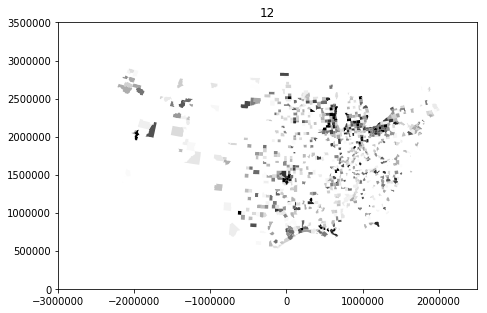

industry_code      sqrt_size cluster  \
190  2111          83.6671978735  13       
191  2131          99.4569421073  13       
10   2212          45.6926325206  13       
200  3251          49.3176776961  13       
38   3331          53.8039651575  13       
314  4861          17.9531798483  13       
283  4862          33.3991017843  13       

                                              industry_title    color  
190  NAICS 2111 Oil and gas extraction                        #ff007c  
191  NAICS 2131 Support activities for mining                 #ff007c  
10   NAICS 2212 Natural gas distribution                      #ff007c  
200  NAICS 3251 Basic chemical manufacturing                  #ff007c  
38   NAICS 3331 Ag., construction, and mining machinery mfg.  #ff007c  
314  NAICS 4861 Pipeline transportation of crude oil          #ff007c  
283  NAICS 4862 Pipeline transportation of natural gas        #ff007c

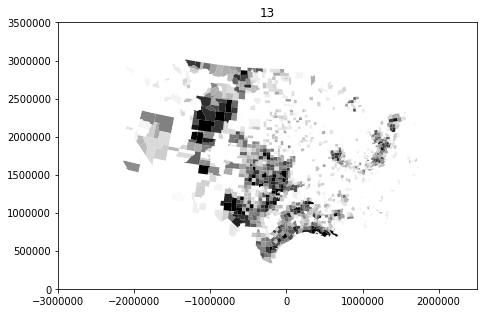

industry_code      sqrt_size cluster  \
266  3131          21.3061024122  14       
24   3132          37.626674935   14       
286  3151          23.4815530435  14       
197  3152          100.258083631  14       
296  3161          15.4429055988  14       
313  3162          16.2347364212  14       
272  3274          18.728765754   14       
312  3343          24.2480239745  14       
221  3351          35.4412659669  14       
224  3364          50.5648098978  14       
57   4249          189.77574485   14       
97   5121          144.296396351  14       
315  5174          29.2195710669  14       
138  6113          88.0654112956  14       
270  6222          36.1699691273  14       
155  7115          132.758301686  14       
176  8141          721.109191917  14       

                                              industry_title    color  
266  NAICS 3131 Fiber, yarn, and thread mills                 #c81cff  
24   NAICS 3132 Fabric mills                                  #c81cff  
286  NAICS 3151 Apparel knitting mills                        #c81cff  
197  NAICS 3152 Cut and sew apparel manufacturing             #c81cff  
296  NAICS 3161 Leather and hide tanning and finishing        #c81cff  
313  NAICS 3162 Footwear manufacturing                        #c81cff  
272  NAICS 3274 Lime and gypsum product manufacturing         #c81cff  
312  NAICS 3343 Audio and video equipment manufacturing       #c81cff  
221  NAICS 3351 Electric lighting equipment manufacturing     #c81cff  
224  NAICS 3364 Aerospace product and parts manufacturing     #c81cff  
57   NAICS 4249 Misc. nondurable goods merchant wholesalers   #c81cff  
97   NAICS 5121 Motion picture and video industries           #c81cff  
315  NAICS 5174 Satellite telecommunications                  #c81cff  
138  NAICS 6113 Colleges and universities                     #c81cff  
270  NAICS 6222 Psychiatric and substance abuse hospitals     #c81cff  
155  NAICS 7115 Independent artists, writers, and performers  #c81cff  
176  NAICS 8141 Private households                            #c81cff

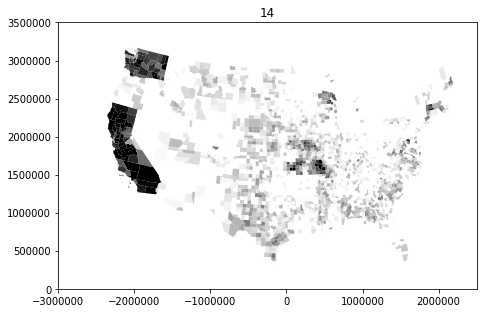

industry_code      sqrt_size cluster  \
185  1112          64.6918335908  15       
289  1113          118.245930163  15       
1    1119          105.039278368  15       
2    1121          110.553682285  15       
186  1123          37.3503681374  15       
316  1124          16.11262445    15       
3    1129          50.4541045572  15       
4    1132          15.1520075678  15       
6    1151          94.5347378833  15       
192  3111          39.3535258903  15       
202  3253          29.7430664189  15       

                                              industry_title    color  
185  NAICS 1112 Vegetable and melon farming                   #d468f3  
289  NAICS 1113 Fruit and tree nut farming                    #d468f3  
1    NAICS 1119 Other crop farming                            #d468f3  
2    NAICS 1121 Cattle ranching and farming                   #d468f3  
186  NAICS 1123 Poultry and egg production                    #d468f3  
316  NAICS 1124 Sheep and goat farming                        #d468f3  
3    NAICS 1129 Other animal production                       #d468f3  
4    NAICS 1132 Forest nursery and gathering forest products  #d468f3  
6    NAICS 1151 Support activities for crop production        #d468f3  
192  NAICS 3111 Animal food manufacturing                     #d468f3  
202  NAICS 3253 Agricultural chemical manufacturing           #d468f3

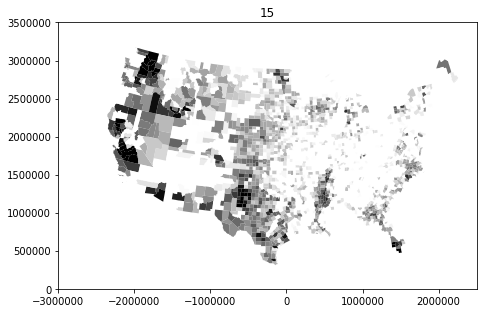

industry_code      sqrt_size cluster  \
304  3346          36.0423362173  16       
43   3399          134.903484017  16       
45   4232          104.00961494   16       
74   4483          167.140410035  16       
76   4512          136.479058223  16       
83   4541          100.296809521  16       
241  5111          151.110224671  16       
98   5151          80.1875925565  16       
99   5152          37.7454191481  16       
100  5161          56.0370413209  16       
111  5231          176.624554729  16       
311  5232          16.3849524463  16       
243  5239          195.113214998  16       
305  5251          44.2332830947  16       
114  5311          327.918739934  16       
246  5331          53.4883164813  16       
247  5414          180.794773155  16       
126  5418          217.258946881  16       
133  5615          159.852014897  16       
253  6117          84.4803724739  16       
259  7113          68.7866266072  16       
171  8129          161.834843797  16       
263  8132          104.059117813  16       
173  8133          118.915936695  16       

                                               industry_title    color  
304  NAICS 3346 Magnetic media manufacturing and reproducing   #f3b3f5  
43   NAICS 3399 Other miscellaneous manufacturing              #f3b3f5  
45   NAICS 4232 Furniture and furnishing merchant wholesalers  #f3b3f5  
74   NAICS 4483 Jewelry, luggage, and leather goods stores     #f3b3f5  
76   NAICS 4512 Book stores and news dealers                   #f3b3f5  
83   NAICS 4541 Electronic shopping and mail-order houses      #f3b3f5  
241  NAICS 5111 Newspaper, book, and directory publishers      #f3b3f5  
98   NAICS 5151 Radio and television broadcasting              #f3b3f5  
99   NAICS 5152 Cable and other subscription programming       #f3b3f5  
100  NAICS02 5161 Internet publishing and broadcasting         #f3b3f5  
111  NAICS 5231 Securities and commodity contracts brokerage   #f3b3f5  
311  NAICS 5232 Securities and commodity exchanges             #f3b3f5  
243  NAICS 5239 Other financial investment activities          #f3b3f5  
305  NAICS 5251 Insurance and employee benefit funds           #f3b3f5  
114  NAICS 5311 Lessors of real estate                         #f3b3f5  
246  NAICS 5331 Lessors of nonfinancial intangible assets      #f3b3f5  
247  NAICS 5414 Specialized design services                    #f3b3f5  
126  NAICS 5418 Advertising, pr, and related services          #f3b3f5  
133  NAICS 5615 Travel arrangement and reservation services    #f3b3f5  
253  NAICS 6117 Educational support services                   #f3b3f5  
259  NAICS 7113 Promoters of performing arts and sports        #f3b3f5  
171  NAICS 8129 Other personal services                        #f3b3f5  
263  NAICS 8132 Grantmaking and giving services                #f3b3f5  
173  NAICS 8133 Social advocacy organizations                  #f3b3f5

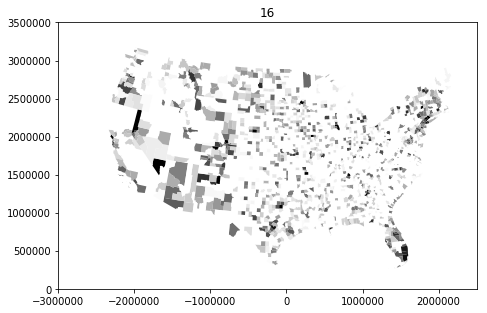

In [220]:
for col in gdf_scaled_std.iloc[:, :-1].columns:
# for col in ['0', '1', '2']:
#     display(nodes.loc[nodes.cluster == int(col)].sort_values('industry_code').sample(6, replace = True))

    display(nodes.loc[nodes.cluster == str(int(col))].sort_values('industry_code'))#.sample(6, replace = True))
    hist = pd.cut(gdf_scaled_std[col], np.arange(-3, 5, .25))
    mode_level = hist.loc[hist != pd.Interval(-2.25, -2.0, closed='right')].mode()[0].mid
    vmin = mode_level
    vmax = gdf_scaled_std[col].quantile(.99)
    
# #     norm = colors.Normalize(vmin=gdf_scaled[col].quantile(.5), vmax=gdf_scaled[col].quantile(.9))
#     norm = colors.Normalize(vmin=0, vmax=2)
#     cmap = cm.ScalarMappable(norm=norm, cmap=cm.gray_r)
#     ec = [cmap.to_rgba(cl) for cl in gdf_scaled[col].values]
    
#     ax = gdf_scaled_std.to_crs(fancy_crs).plot(column = col, color = 'None',  edgecolor=ec,
#                          linewidth = .5, figsize = (7.5, 6))
    

#     vmin = gdf_scaled_std[col].quantile(.05)
#     vmax = gdf_scaled_std[col].quantile(.95)
    
    ax = gdf_scaled_std.to_crs(fancy_crs).plot(column = col, cmap=plt.cm.gray_r, 
                         vmin = vmin, vmax = vmax, 
                         linewidth = 0, figsize = (7.5, 6))

    ax.set_title(col)
    ax.set_xlim(-3e6, 2.5e6)
    ax.set_ylim(0, 3.5e6)
#     ax.set_xlim(-1.5e7, -.7e7)
#     ax.set_ylim(.2e7, .7e7)#, figsize=figsize, scheme='equal_interval', k=colors, legend=True)
#     ax.axis('off')
    plt.show()

In [221]:
## Network, choosing key clusters

In [222]:
nodes_['color_edit'] = nodes_['color']
nodes_.loc[nodes_.cluster.isin([2, 5, 6, 7, 8, 9, 10, 12, 15, 16, 17]), 'color_edit'] = '#b3b3b3'

nodes_.loc[~nodes_.cluster.isin([2, 5, 6, 7, 8, 9, 10, 12, 15, 16, 17])][['cluster', 'color']].drop_duplicates()

cluster    color
2   0        #d3d3d3
6   14       #c81cff
13  11       #ff990a
26  13       #ff007c
35  3        #00d3ff
66  4        #00fdcb
95  1        #005127

In [223]:
name = 'clusters'; color = 'color_edit';

ps = d3plus.ProductSpace(
id="name",
name="industry_title",
color=color,
graph_data=network,
presence="presence",
edge_property="edges",
network_id="id")

ps.draw(nodes_)
name = name
visualization_html = ps.dump_html(nodes_)
file_ = name + '_nwplot.html'
link = "http://matiasdice.com/other/"+file_
open('./html/'+file_, "w+").write(visualization_html);

<IPython.core.display.Javascript object>

In [ ]:
# for col in gdf_scaled_std.iloc[:, :-1].columns:
#     plt.hist(gdf_scaled_std[col], np.arange(-3, 5, .25))
    
#     hist = pd.cut(gdf_scaled_std[col], np.arange(-3, 5, .25))
#     mode_level = hist.loc[hist != pd.Interval(-2.25, -2.0, closed='right')].mode()[0].mid
#     plt.axvline(mode_level, c = 'k')
#     plt.axvline(gdf_scaled_std[col].quantile(.99), c = 'k')
#     plt.show()

In [ ]:
# county_fips = gdf_scaled_std.index
# # df = gdf_scaled_std.sort_index()

# # for col in gdf_scaled_std.iloc[:, :-1].columns:
# for col in ['2']:
#     fig, ax = plt.subplots(1, figsize = (5 * (3 + 2.5)/3.5, 5))
    
#     hist = pd.cut(gdf_scaled_std[col], np.arange(-3, 5, .25))
#     mode_level = hist.loc[hist != pd.Interval(-2.25, -2.0, closed='right')].mode()[0].mid
#     vmin = mode_level
#     vmax = gdf_scaled_std[col].quantile(.99)
    
#     for fips in county_fips:
#         df = gdf_scaled_std.loc[[fips]]
    
    
#     #     display(nodes.loc[nodes.cluster == int(col)].sort_values('industry_code'))

#     # #     norm = colors.Normalize(vmin=gdf_scaled[col].quantile(.5), vmax=gdf_scaled[col].quantile(.9))



#     #     cmap = cm.ScalarMappable(norm=colors.Normalize(vmin=vmin, vmax=vmax), cmap=cm.gray_r)
#         cmap = cm.ScalarMappable(norm=colors.Normalize(vmin=vmin, vmax=vmax), cmap=cm.jet)
# #         ec = [cmap.to_rgba(cl) for cl in df[col].values]
#         ec = cmap.to_rgba(df[col]) # for individual county

#         df.to_crs(fancy_crs).plot(column = col, color = 'None',  edgecolor=ec,
#                              linewidth = 1, ax = ax, alpha = .5)

#     ax.set_title(col)
#     ax.set_xlim(-3e6, 2.5e6)
#     ax.set_ylim(0, 3.5e6)

# # # wyoming
# #     ax.set_xlim(-1.3e6, -.6e6)
# #     ax.set_ylim(2e6, 2.6e6)

# #     ax.set_xlim(-1.5e7, -.7e7)
# #     ax.set_ylim(.2e7, .7e7)#, figsize=figsize, scheme='equal_interval', k=colors, legend=True)
# #     ax.axis('off')
#     plt.show()